# Load Lirbrary

In [1]:
import subprocess
import os
import re
import shutil
from pathlib import Path
import sys

In [2]:
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import librosa
import librosa.display
import seaborn as sns

/home/seola/miniconda3/envs/mood/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# import torch
# import torch.nn as nn
# import umap

In [4]:
from utils import *

# Load data

In [5]:
df = pd.read_csv("../../result.csv", encoding='utf-8-sig')
df.head()

,musicId,fileName,title,artist,album,genre,genre_grouped,audio_arousal,audio_valence,audio_emotion_quadrant_label,...,mfcc_9_mean,mfcc_9_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std,centroid_mean,centroid_std
0,6,21 Savage - Red Opps,Red Opps,21 Savage,Red Opps,Hip-Hop,Hip-Hop,0.5125,0.3500,Q3,...,10.533357,12.852773,2.004004,12.051487,3.299934,10.632957,3.232832,9.367224,2665.729652,1093.967678
1,9,A Boogie Wit Da Hoodie - Timeless,Timeless,A Boogie Wit Da Hoodie,TBA,Hip-Hop,Hip-Hop,0.4500,0.2875,Q3,...,3.207154,13.030756,-0.128748,10.019030,10.942307,9.434628,7.098895,9.990342,1913.728754,1013.210948
2,17,Adele - Hello,Hello,Adele,Hello,Pop,Pop,0.8250,0.6750,Q1,...,8.310090,10.178933,-3.597765,8.906549,-1.684012,9.201923,-3.258988,9.665615,1734.355866,807.404886
3,19,Adele - Water Under The Bridge,Water Under The Bridge,Adele,25,Pop,Pop,0.7625,0.7500,Q1,...,8.630644,9.580266,0.887758,8.133497,5.430757,7.340950,-3.104878,7.815466,2029.131425,747.292268
4,20,Al Jarreau - We're In This Love Together,We're In This Love Together,Al Jarreau,Breakin' Away,R&B,Pop,0.5500,0.6375,Q4,...,5.314159,8.505757,-0.296393,9.331346,1.055715,8.237994,-1.468831,8.593241,2059.462304,759.865467


## chordsset columns

In [6]:
df.columns

Index(['musicId', 'fileName', 'title', 'artist', 'album', 'genre',
       'genre_grouped', 'audio_arousal', 'audio_valence',
       'audio_emotion_quadrant_label', 'lyrics_emotion_quadrant_label',
       'match_status', 'emotion_pair', 'YT id', 'duration',
       'matched video title', 'dominant_tempo_variance',
       'tempo_transition_complexity', 'active_bpm_variance', 'pitch_high',
       'pitch_low', 'pitch_range', 'rms_variance', 'repeat_area_size',
       'repetition_ratio', 'repeat_area_size_without_offset',
       'repetition_ratio_without_offset', 'key', 'scale', 'strength',
       'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean',
       'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std',
       'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean',
       'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std',
       'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std',
       'mfcc_12_mean'

## Dataset check

### Count label

In [7]:
df["emotion_pair"].value_counts()

emotion_pair
NN    100
NP    100
PN    100
PP    100
Name: count, dtype: int64

### Count grouped genre per label

> x axis (left to right): negative-match -> negative-mismatch -> positive-mismatch -> positive-match

1. Rock
    - negative-match & positive-match 곡은 중간 정도의 유사한 곡 비율을 가짐
    - 그에 반해 mismatch 곡은 편차가 큼
    - positive-mismatch 곡의 Rock 비중이 가장 높고, negative-mismatch 곡의 Rock 비중이 가장 낮음
        - 긍정적인 오디오와 부정적인 가사 간의 감정 불일치를 극대화하려는 장치로 Rock 장르가 활용되었을 가능성

2. Pop/Country
    - negative-match < negative-mismatch < positive-mismatch < positive-match 순으로 비중이 높음
3. Hip-Hop
    - negative-match > negative-mismatch > positive-mismatch > positive-match 순으로 비중이 높음

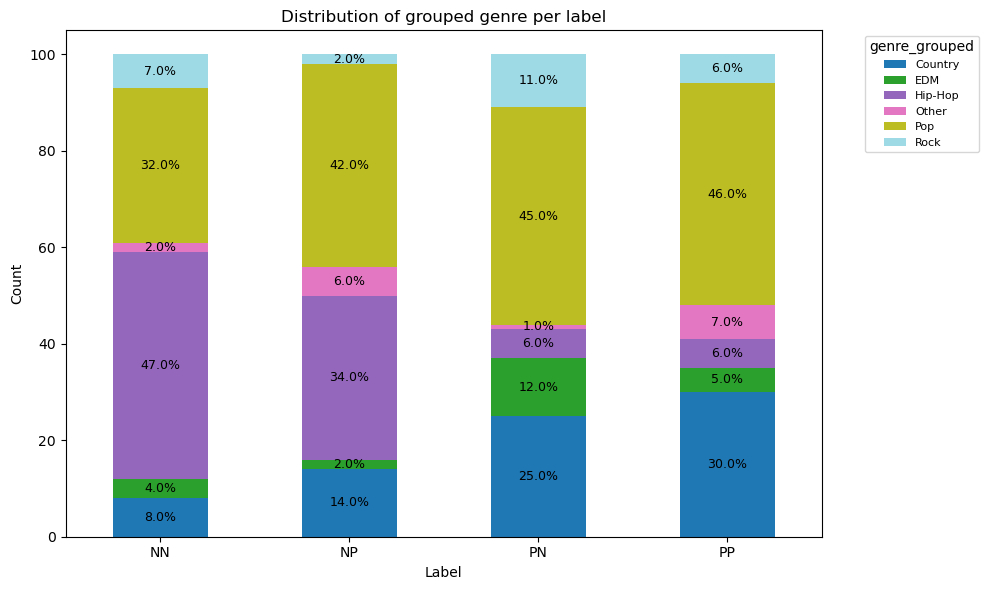

In [8]:
ggenre = df.groupby(['emotion_pair', 'genre_grouped']).size().unstack(fill_value=0)

stacked_barplot(
    ggenre,
    title="Distribution of grouped genre per label",
    xlabel="Label",
    ylabel="Count",
    auto_height_by_legend=False,
    show_values=True,
    percentage=True
)

### Count genre per label

> x axis (left to right): negative-match -> negative-mismatch -> positive-mismatch -> positive-match

1. 세부 장르 분포에 따르면 가사 감정에 따라, 가사 감정이 긍정적인 경우가 그 반대보다 더 다양한 장르 존재

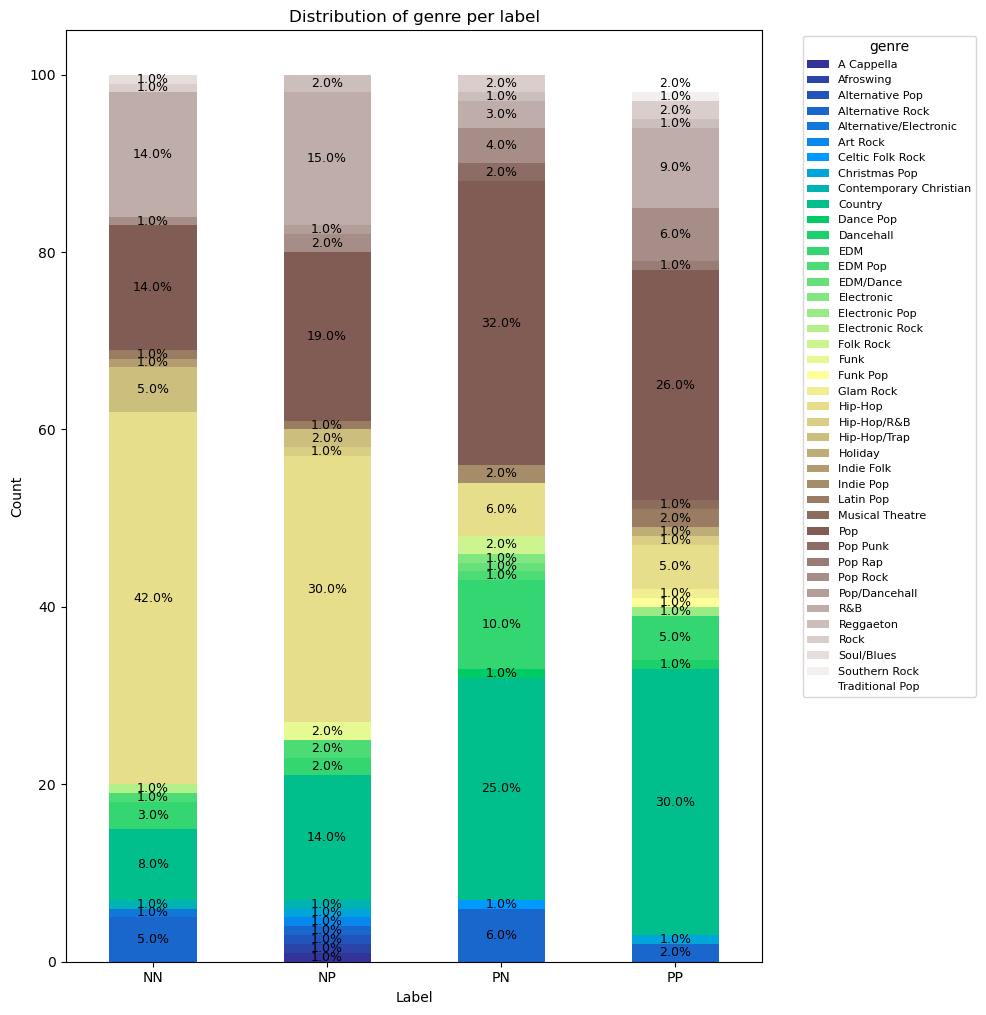

In [9]:
genre = df.groupby(['emotion_pair', 'genre']).size().unstack(fill_value=0)

stacked_barplot(
    genre,
    title="Distribution of genre per label",
    xlabel="Label",
    ylabel="Count",
    cmap_name="terrain",
    show_values=True,
    percentage=True,
    auto_height_by_legend=True
)

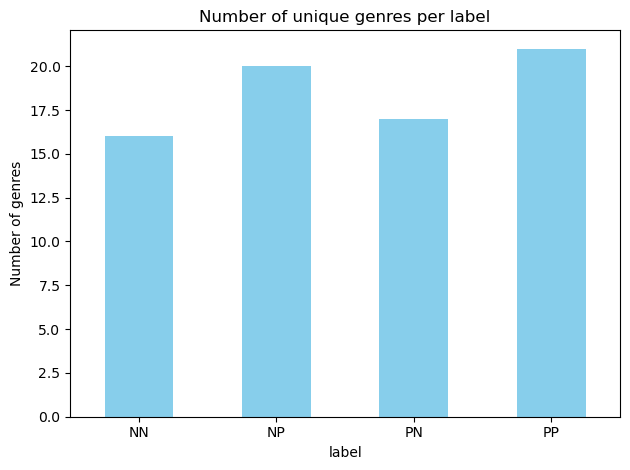

In [10]:
import matplotlib.pyplot as plt

genre_counts_per_label = (genre > 0).sum(axis=1)

genre_counts_per_label.plot(kind='bar', color='skyblue')
plt.title("Number of unique genres per label")
plt.xlabel("label")
plt.ylabel("Number of genres")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [11]:
empty_genre_table = (genre == 0).T
empty_genre_table

emotion_pair,NN,NP,PN,PP
genre,,,,
A Cappella,True,False,True,True
Afroswing,True,False,True,True
Alternative Pop,True,False,True,True
Alternative Rock,False,False,False,False
Alternative/Electronic,False,True,True,True
Art Rock,True,False,True,True
Celtic Folk Rock,True,True,False,True
Christmas Pop,True,False,True,False
Contemporary Christian,False,False,True,True


# Pitch Range

1. 가장 높은 peak는 모든 라벨에서 유사
2. positive-mismatch > positive-match > negative-mismatch > negative-match 순으로 밀도 높음
3. positive-mismatch가 가장 pitch range가 좁고 일정
    - positive-mismatch인 곡은 타 라벨의 곡들에 비해 제한된 범위의 피치 사용 -> pitch range가 넓은 negative-match 곡과는 상반된 오디오 특성 가짐
4. negative-match는 이상치 포함, pitch range 가장 넓은 곡 존재

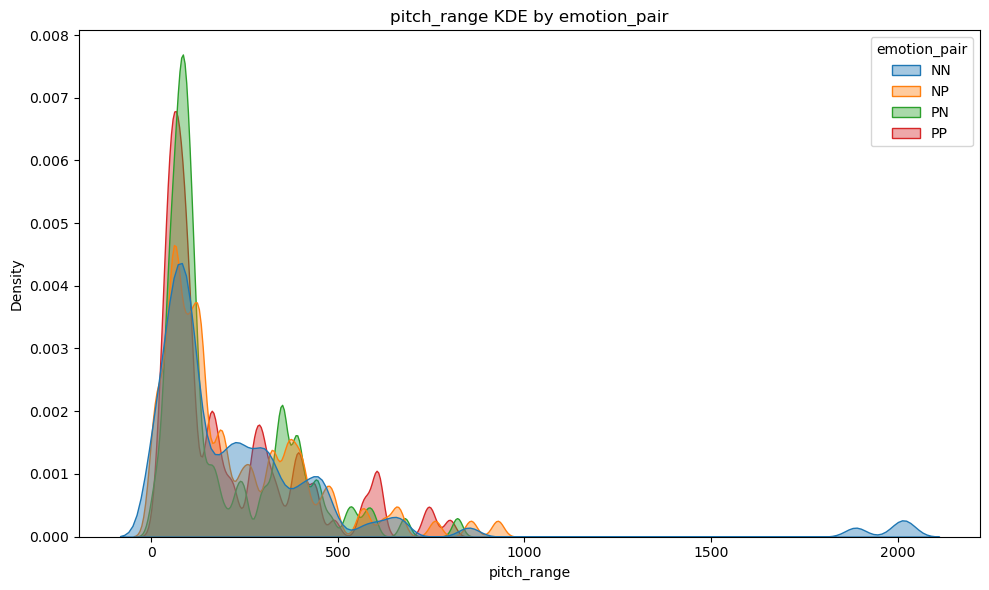

In [12]:
plot_kde(df, value_col="pitch_range", group_col="emotion_pair")

# RMS Variance

1. peak 값은 유사, 밀도는 negative-match -> negative-mismatch -> positive-mismatch -> positive-match 순으로 높음
2. negative-match는 가장 볼륨의 변화가 다양한 편이고, positive-match는 균일한 편
3. mismatch 곡들은 일부 variance가 극단적으로 큰 곡들이 존재

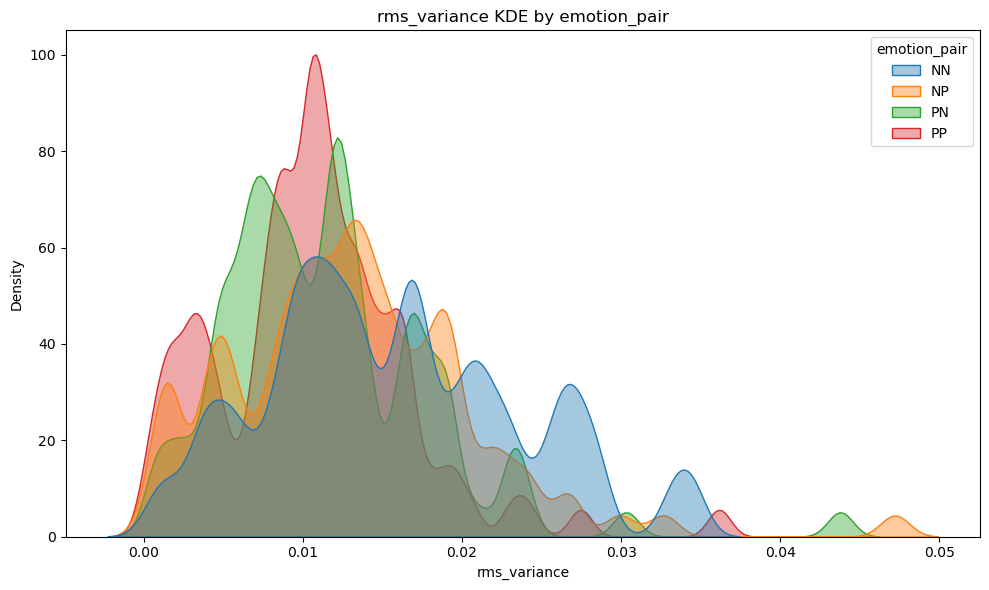

In [13]:
plot_kde(df, value_col="rms_variance", group_col="emotion_pair", bw_adjust=0.3)

# MFCC

> x axis (left to right): negative-match -> negative-mismatch -> positive-mismatch -> positive-match

## MFCC Mean (4 - 12)

1. negative-match 곡들이 대체로 outlier 많음, 곡들 간의 일관성이 떨어짐
    - 따라서 negative-match 곡들의 장르가 positive-match곡들에 비해 다양성을 가진다고 추론해볼 수 있음 -> 각 분류별 장르 분포 체크 필요!
2. positive-match 곡들이 가장 outlier 적음, 타 분류 곡들에 비해 경향성이 보다 뚜렷
3. 하지만 mismatch 곡들에 대한 차이는 분별하기 수준이며 전체적으로 중앙값이나 박스 위치, 크기가 유사하여 네 분류 간의 유의미한 차이를 분석하기 어려움

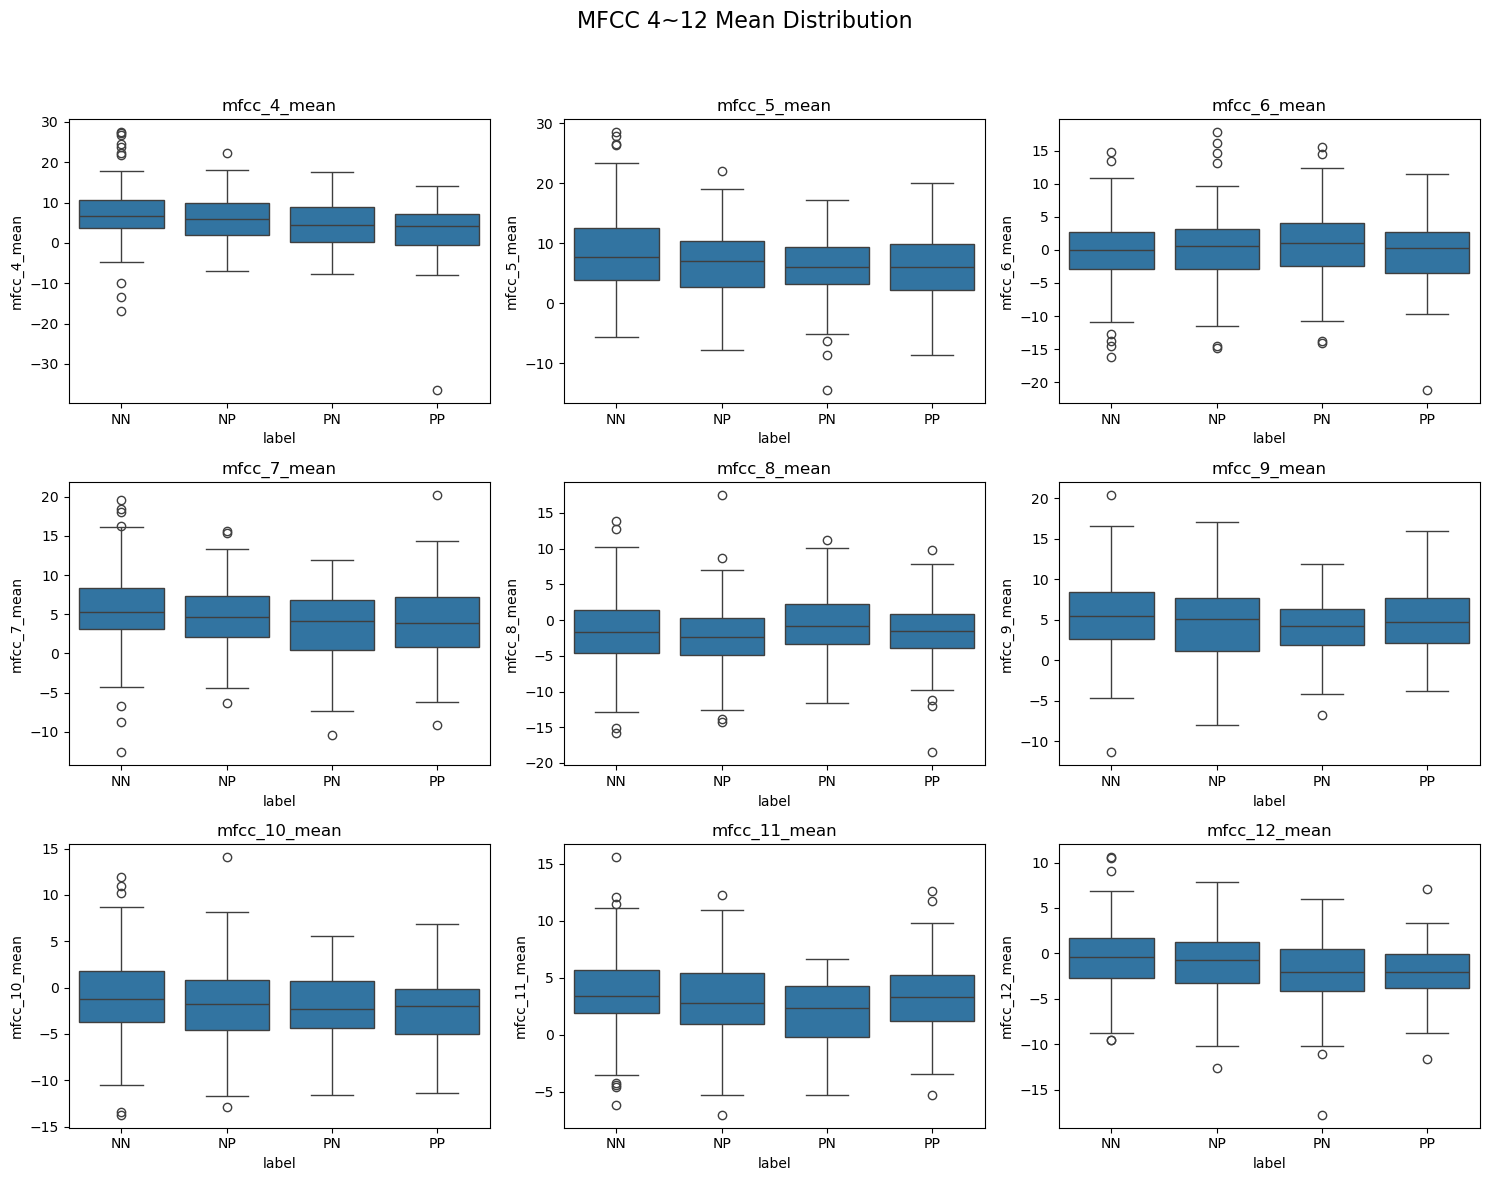

In [14]:
plot_mfcc_boxplots(
    df,
    col_range=range(4, 13),
    stat="mean",
    group_col="emotion_pair",
    grid_shape=(3, 3),
    suptitle="MFCC 4~12 Mean Distribution"
)

## MFCC Std (4 - 12)

1. 대체로 negative-match -> negative-mismatch -> positive-mismatch -> positive-match 순으로 표준편차 중앙값이 낮아지는 경향성이 있음
2. 특히나 거의 모든 계수에서 mfcc의 std값이 negative-match > negative-mismatch 의 양상을 보임

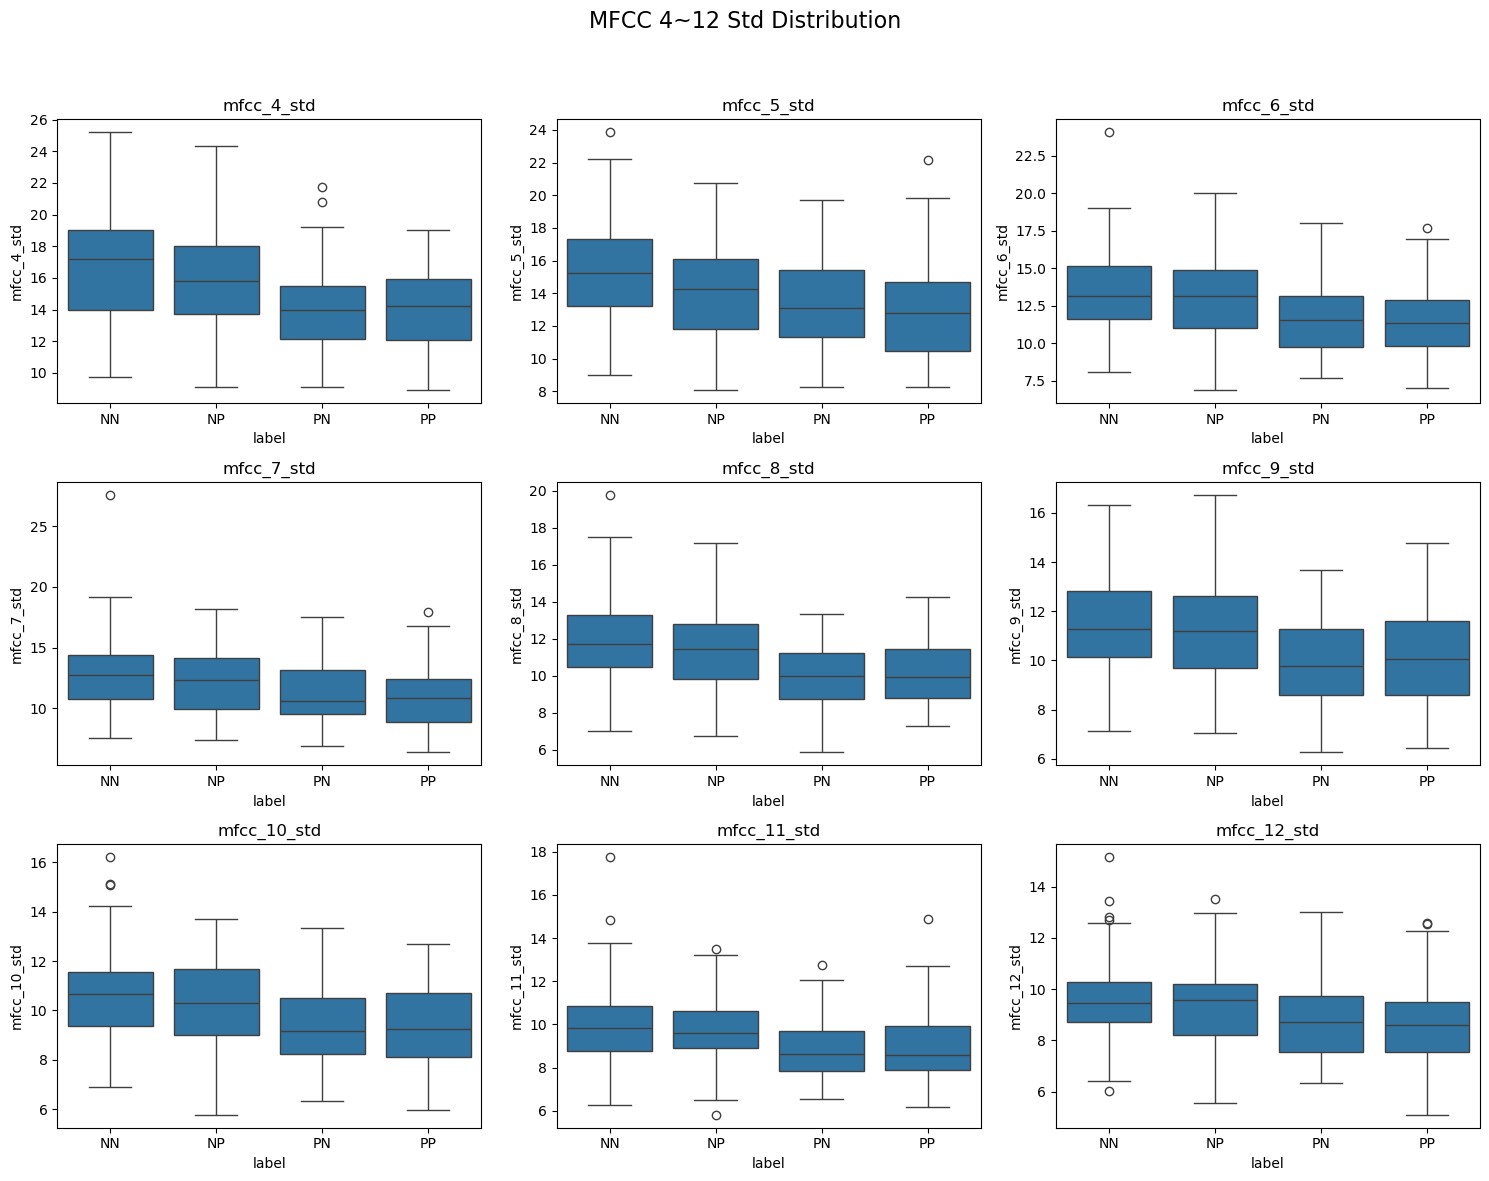

In [15]:
plot_mfcc_boxplots(
    df,
    col_range=range(4, 13),
    stat="std",
    group_col="emotion_pair",
    grid_shape=(3, 3),
    suptitle="MFCC 4~12 Std Distribution"
)

# Centroid

## Centroid Mean

- 인사이트를 얻을 만한 정보 없음

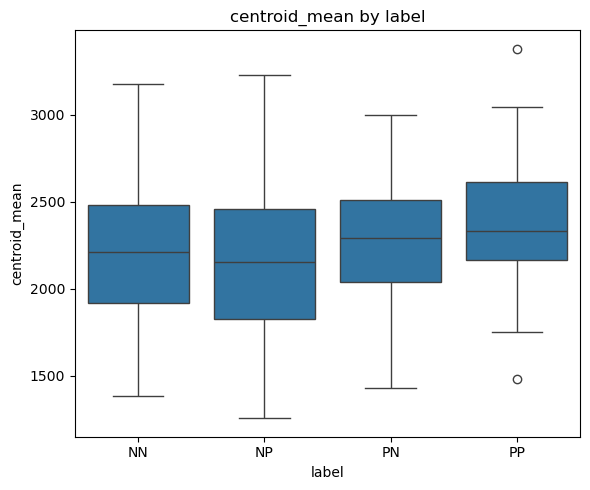

In [18]:
plot_single_boxplot(df, feature="centroid_mean")

## Centroid Std

1. negative-match > negative-mismatch > positive-mismatch > positive-match 순으로 spectral centroid의 편차가 큼

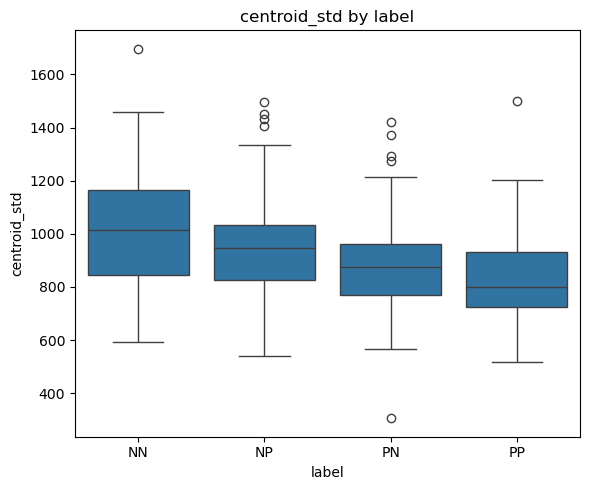

In [19]:
plot_single_boxplot(df, feature="centroid_std")

## Centroid Mean & Std

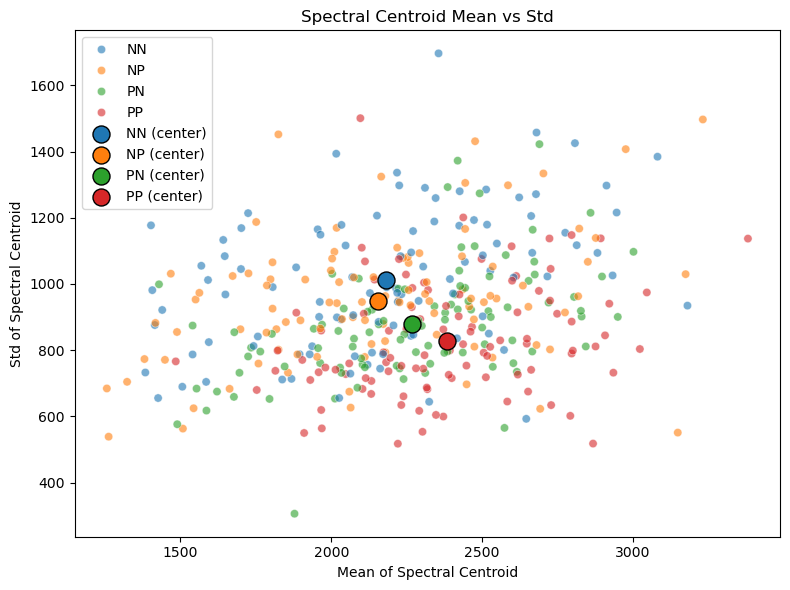

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    chords=df,
    x="centroid_mean",
    y="centroid_std",
    hue="emotion_pair",
    alpha=0.6
)

centers = df.groupby("emotion_pair")[["centroid_mean", "centroid_std"]].mean()

for label, row in centers.iterrows():
    plt.scatter(row["centroid_mean"], row["centroid_std"],
                color=sns.color_palette()[list(centers.index).index(label)],
                edgecolor="black", s=150, marker="o", label=f"{label} (center)")

plt.title("Spectral Centroid Mean vs Std")
plt.xlabel("Mean of Spectral Centroid")
plt.ylabel("Std of Spectral Centroid")
plt.legend()
plt.tight_layout()
plt.show()

# Chord

In [1]:
from madmom.processors import SequentialProcessor
from madmom.audio.chroma import DeepChromaProcessor
from madmom.features.chords import DeepChromaChordRecognitionProcessor

dcp = DeepChromaProcessor()
decode = DeepChromaChordRecognitionProcessor()
chordrec = SequentialProcessor([dcp, decode])
chords = chordrec('opera.wav')

In [2]:
chords.shape

(31,)

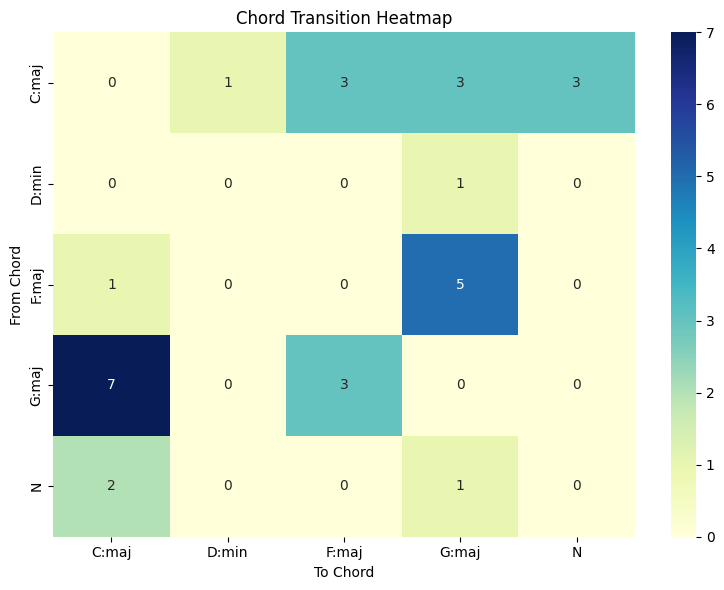

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

transitions = []
for i in range(len(chords) - 1):
    from_chord = chords[i][2]
    to_chord = chords[i + 1][2]
    transitions.append((from_chord, to_chord))

df = pd.chordsFrame(transitions, columns=["from", "to"])
transition_matrix = pd.crosstab(df["from"], df["to"])

plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Chord Transition Heatmap")
plt.xlabel("To Chord")
plt.ylabel("From Chord")
plt.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

def chord_duration_analysis(chords):
    duration_dict = defaultdict(float)
    for start, end, label in chords:
        duration_dict[label] += end - start

    sorted_items = sorted(duration_dict.items(), key=lambda x: -x[1])
    labels, durations = zip(*sorted_items)
    plt.figure(figsize=(8, 4))
    plt.bar(labels, durations)
    plt.ylabel("Total Duration (seconds)")
    plt.title("Chord Duration Analysis")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_chord_timeline(chords, total_duration=None):
    if total_duration is None:
        total_duration = max([end for (_, end, _) in chords])
    
    fig, ax = plt.subplots(figsize=(12, 2))
    for (start, end, label) in chords:
        ax.barh(0, end - start, left=start, height=0.6)
        ax.text((start + end) / 2, 0, label, ha='center', va='center', fontsize=8)

    ax.set_xlim(0, total_duration)
    ax.set_yticks([])
    ax.set_xlabel("Time (s)")
    ax.set_title("Chord Timeline")
    plt.tight_layout()
    plt.show()


In [ ]:
from collections import Counter

def chord_ngram_analysis(chords, n=3, min_count=2):
    labels = [label for (_, _, label) in chords]
    ngrams = [tuple(labels[i:i+n]) for i in range(len(labels) - n + 1)]
    counts = Counter(ngrams)
    common_ngrams = {k: v for k, v in counts.items() if v >= min_count}
    sorted_ngrams = sorted(common_ngrams.items(), key=lambda x: -x[1])
    print(f"Top repeated {n}-grams (min count: {min_count}):")
    for pattern, count in sorted_ngrams:
        print(f"{pattern} -> {count} times")


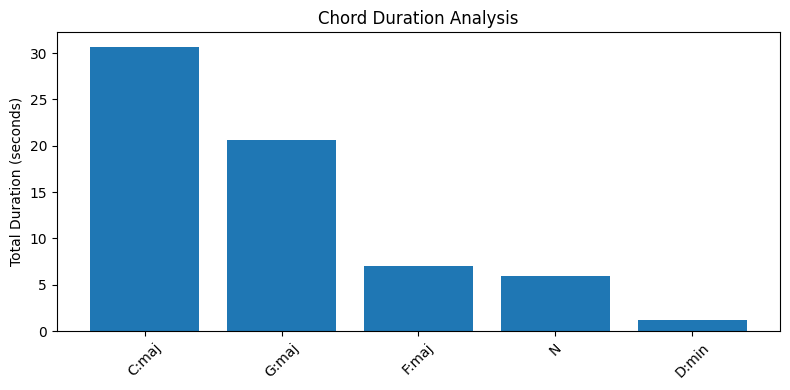

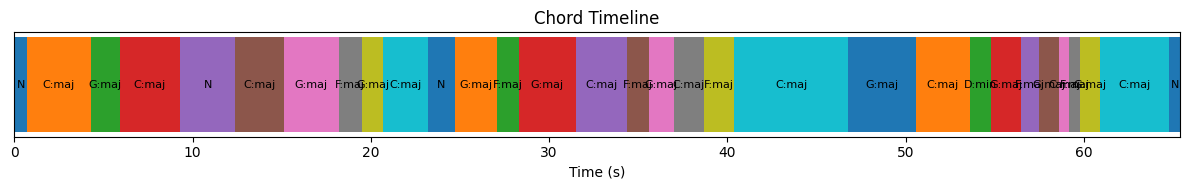

Top repeated 3-grams (min count: 2):
('F:maj', 'G:maj', 'C:maj') -> 5 times
('G:maj', 'C:maj', 'N') -> 3 times
('G:maj', 'F:maj', 'G:maj') -> 3 times
('G:maj', 'C:maj', 'F:maj') -> 3 times
('N', 'C:maj', 'G:maj') -> 2 times
('C:maj', 'G:maj', 'C:maj') -> 2 times
('C:maj', 'F:maj', 'G:maj') -> 2 times


In [ ]:
chord_duration_analysis(chords)
plot_chord_timeline(chords)
chord_ngram_analysis(chords, n=3, min_count=2)

In [9]:
from collections import Counter

def find_repeated_ngrams(data, min_n=2, max_n=None, min_count=2):
    labels = [label for (_, _, label) in data]
    max_n = max_n or len(labels) - 1

    for n in range(min_n, max_n + 1):
        ngrams = [tuple(labels[i:i+n]) for i in range(len(labels) - n + 1)]
        counts = Counter(ngrams)
        filtered = [(ng, c) for ng, c in counts.items() if c >= min_count]

        if filtered:
            print(f"{n}-gram patterns:")
            for pattern, count in sorted(filtered, key=lambda x: -x[1]):
                print(f"{pattern} : {count}")
            print()

In [10]:
find_repeated_ngrams(chords, min_n=2, min_count=2)

2-gram patterns:
('G:maj', 'C:maj') : 7
('F:maj', 'G:maj') : 5
('C:maj', 'G:maj') : 3
('C:maj', 'N') : 3
('G:maj', 'F:maj') : 3
('C:maj', 'F:maj') : 3
('N', 'C:maj') : 2

3-gram patterns:
('F:maj', 'G:maj', 'C:maj') : 5
('G:maj', 'C:maj', 'N') : 3
('G:maj', 'F:maj', 'G:maj') : 3
('G:maj', 'C:maj', 'F:maj') : 3
('N', 'C:maj', 'G:maj') : 2
('C:maj', 'G:maj', 'C:maj') : 2
('C:maj', 'F:maj', 'G:maj') : 2

4-gram patterns:
('G:maj', 'F:maj', 'G:maj', 'C:maj') : 3
('F:maj', 'G:maj', 'C:maj', 'F:maj') : 3
('F:maj', 'G:maj', 'C:maj', 'N') : 2
('G:maj', 'C:maj', 'F:maj', 'G:maj') : 2
('C:maj', 'F:maj', 'G:maj', 'C:maj') : 2

5-gram patterns:
('G:maj', 'F:maj', 'G:maj', 'C:maj', 'F:maj') : 2
('F:maj', 'G:maj', 'C:maj', 'F:maj', 'G:maj') : 2
('G:maj', 'C:maj', 'F:maj', 'G:maj', 'C:maj') : 2

6-gram patterns:
('G:maj', 'F:maj', 'G:maj', 'C:maj', 'F:maj', 'G:maj') : 2
('F:maj', 'G:maj', 'C:maj', 'F:maj', 'G:maj', 'C:maj') : 2

7-gram patterns:
('G:maj', 'F:maj', 'G:maj', 'C:maj', 'F:maj', 'G:maj', 